# Analysis - Sex Offender Potential Noncompliance

Looking into the results of [geodata fusion](Geodata%20Fusion.ipynb) and the sex offender locations in order to identify sex offenders who reside within a restricted area. 

# NEED TO REDUCE DATA DOWN TO STL CITY COUNTY

In [1]:
# IMPORTS
import geopandas as gpd
import pandas as pd

import os
import urllib.request
import requests
import shutil
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib import pyplot

import folium

from shapely.geometry import Point, Polygon

from geopandas.tools import overlay

In [2]:
# pip install GeoAlchemy2

In [3]:
# a few more imports specfic to the database process
# import geoalchemy2 # this is only needed if we're going to load data back into PostGIS
import getpass

import psycopg2
import numpy
from psycopg2.extensions import adapt, register_adapter, AsIs

from sqlalchemy import create_engine


### Establish database connection

In [4]:
# get user password for connecting to the db
mypasswd = getpass.getpass()

········


In [36]:
# set up db connection
conn = psycopg2.connect(database = 'cappsds_psmd39', 
                              user = 'psmd39', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)


In [37]:
# establish cursor and read the existing tables
cursor = conn.cursor()

cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables = [i[0] for i in cursor.fetchall()] # A list() of tables.
tables.sort()
tables


['country_borders',
 'gadm_admin_borders',
 'geonames_feature',
 'msorfailedgeocoding',
 'msorfailedgeocodingv2',
 'spatial_ref_sys',
 'stlchildcare',
 'stlnonrestrictedresidential',
 'stlnonrestrictedresparcels',
 'stlpubschools',
 'stlpvtschools',
 'stlresparcels',
 'stlrestrictedflat',
 'stlsexoffenders',
 'stlzoning']

#### Pull sex offender location data from PostGIS database

In [21]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT *, geometry as geom FROM stlsexoffenders;"
gdf_so = gpd.read_postgis(sql, conn)
gdf_so = gdf_so.drop(columns='geometry') # drop the duplicate geometry column
gdf_so.head()


,randomid,name,address,city,st,zip,county,offense,count,compliant,tier,lat,long,geom
0,11929,"ABBOTT, STEVEN R",1621 N 1ST ST,SAINT LOUIS,MO,63102,ST LOUIS CITY,CHILD MOLEST-1ST DEGREE,1,Y,3,38.641888,-90.183579,POINT (-90.18358 38.64189)
1,14856,"ABBOTT, STEVEN R",1621 N 1ST ST,SAINT LOUIS,MO,63102,ST LOUIS CITY,SEXUAL MISCONDUCT-1ST,1,Y,3,38.641888,-90.183579,POINT (-90.18358 38.64189)
2,12469,"ABBOTT, STEVEN R",1621 N 1ST ST,SAINT LOUIS,MO,63102,ST LOUIS CITY,STAT SODOMY-1ST DEG-PERS UND 14,1,Y,3,38.641888,-90.183579,POINT (-90.18358 38.64189)
3,5440,"ABERNATHY, STEVIE A",133 BAYVIEW DR,SAINT LOUIS,MO,63135,ST LOUIS,STATUTORY RAPE-2ND DEGRE,1,Y,3,38.744944,-90.290619,POINT (-90.29062 38.74494)
4,6781,"ABRAMS, NORVELL L",1946 HEBERT ST,SAINT LOUIS,MO,63107,ST LOUIS CITY,ATTEMPT SEXUAL ABUSE,1,Y,2,38.654602,-90.201029,POINT (-90.20103 38.65460)


#### Pull restricted area geometry from PostGIS database

In [38]:
# create sql statement and pull from db into a geopandas dataframe
sql = "SELECT *, geometry as geom FROM stlrestrictedflat;"
gdf_restricted = gpd.read_postgis(sql, conn)
gdf_restricted = gdf_restricted.drop(columns='geometry') # drop the duplicate geometry column
gdf_restricted.head()


,geom
0,"MULTIPOLYGON (((268891.224 298458.770, 268887...."


In [39]:
# convert to same CRS as the SO location data
# make sure our datasets are using the same CRS!
print('Starting restricted area (gdf_restricted) CRS:', gdf_restricted.crs)
print('Starting sex offender locations (gdf_so) CRS:', gdf_so.crs)
print('------------')

# convert to a common CRS
gdf_restricted = gdf_restricted.to_crs(gdf_so.crs)
print('New restricted area (gdf_restricted) CRS:', gdf_restricted.crs)


Starting restricted area (gdf_restricted) CRS: epsg:6512
Starting sex offender locations (gdf_so) CRS: epsg:4326
------------
New restricted area (gdf_restricted) CRS: epsg:4326


In [46]:
# DISSOLVE sex offender locations
# gdf_so['dissolve'] = True

# gdf_so_flat = gdf_so.dissolve(by='dissolve')


#### Plot both datasets together

Text(0.5, 1.0, 'Restricted Areas and Sex Offender Locations in St. Louis')

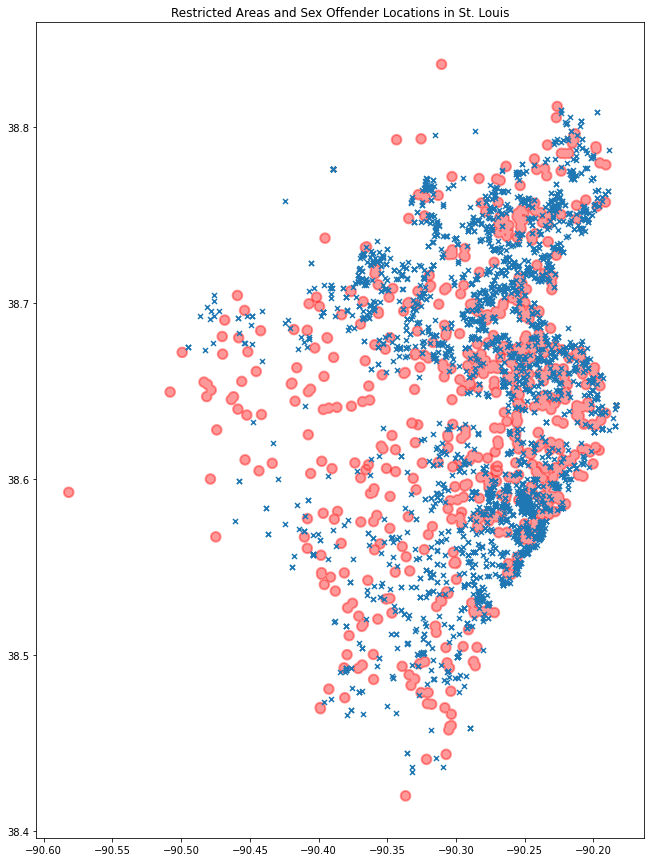

In [69]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_restricted.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so.plot(ax=ax, marker='x', markersize=25)

plt.title("Restricted Areas and Sex Offender Locations in St. Louis")


### Find overlaps

In [72]:
# df1 = gdf_restricted_flat
# df2 = gdf_resparcels
gdf_so['savedindex']= gdf_so.index # Save the index values as a new column

# intersecting = gdf_restricted_flat.sjoin(gdf_resparcels, how='inner')['savedindex'] # this requires gpd v0.10.0+
# Find the polygons that intersect. Keep savedindex as a series.
intersecting = gpd.sjoin(gdf_restricted, gdf_so, how='inner')['savedindex']

gdf_so_compliant = gdf_so[~gdf_so.savedindex.isin(intersecting)] # Filter away these, "savedindex is not in intersecting"
gdf_so_inrestricted = gdf_so[gdf_so.savedindex.isin(intersecting)] 


<AxesSubplot:title={'center':'Sex Offenders Residing INSIDE Restricted Areas'}>

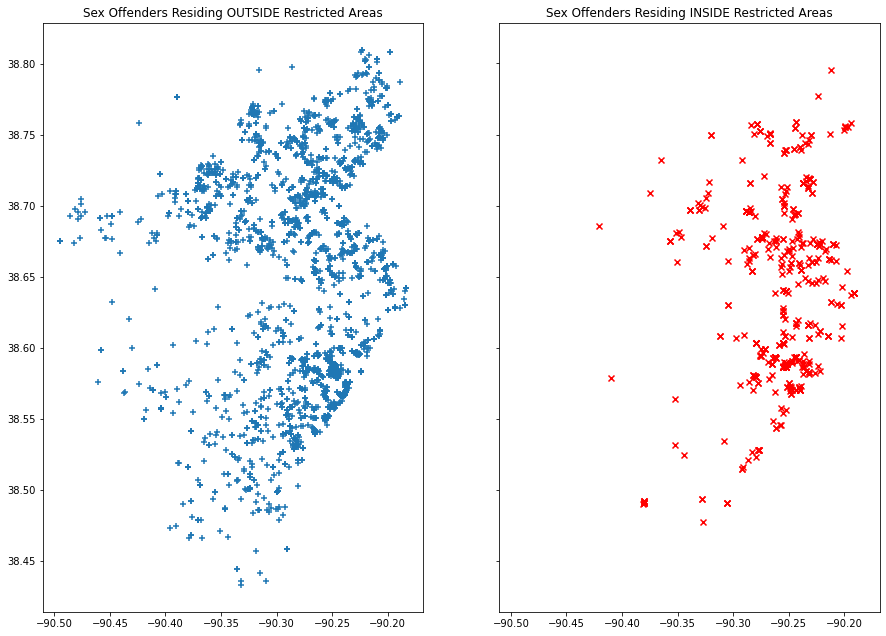

In [76]:
# show before/after plots side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Sex Offenders Residing OUTSIDE Restricted Areas')
ax2.set_title('Sex Offenders Residing INSIDE Restricted Areas')
gdf_so_compliant.plot(ax=ax1, marker='+')
gdf_so_inrestricted.plot(ax=ax2, color='red', marker='x')


Text(0.5, 1.0, 'Restricted Areas and Sex Offender Locations in St. Louis')

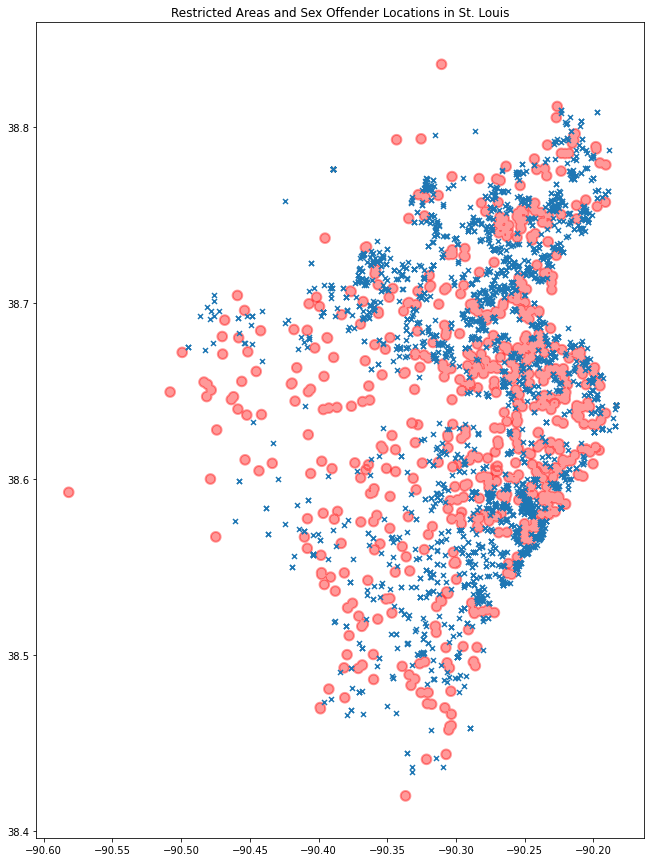

In [80]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_restricted.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_compliant.plot(ax=ax, marker='x', markersize=25)

plt.title("Restricted Areas and Sex Offender Locations in St. Louis")


Text(0.5, 1.0, 'Restricted Areas and Sex Offender Locations in St. Louis')

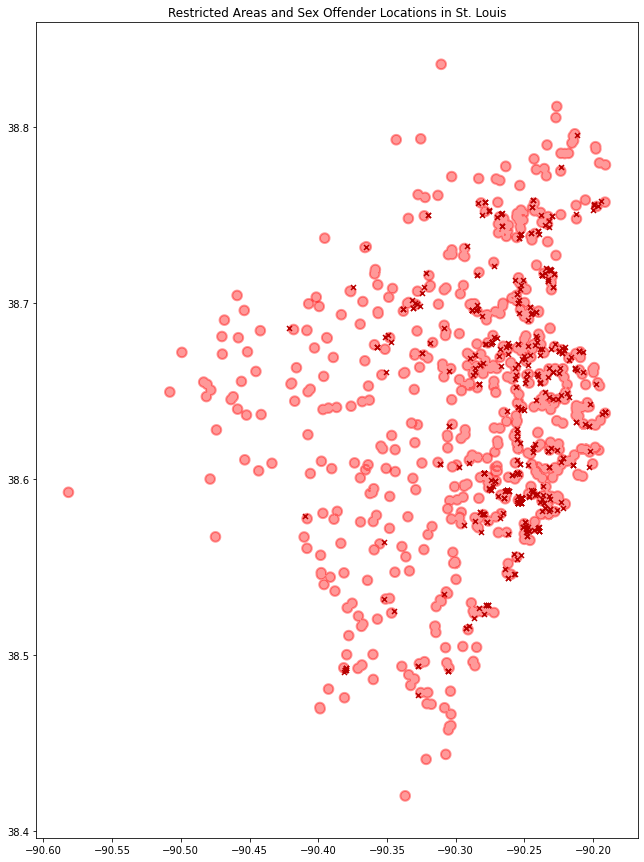

In [83]:
fig, ax = plt.subplots(figsize=(15, 15))

gdf_restricted.plot(ax=ax, color='red', alpha=0.4, edgecolor='red', linewidth=2)
gdf_so_inrestricted.plot(ax=ax, color='#b80000', marker='x', markersize=25)

plt.title("Restricted Areas and Sex Offender Locations in St. Louis")


### Dig into dataframes to summarize counts, classifications, etc.

In [84]:
gdf_so_inrestricted.head()

,randomid,name,address,city,st,zip,county,offense,count,compliant,tier,lat,long,geom,restricted,savedindex
9,6290,"ADAMS, KEITH L",1231 WALDRON AVE,SAINT LOUIS,MO,63130,ST LOUIS,FORCIBLE RAPE,1,Y,3,38.671625,-90.324798,POINT (-90.32480 38.67163),True,9
10,13355,"ADAMS, KEITH L",1231 WALDRON AVE,SAINT LOUIS,MO,63130,ST LOUIS,SODOMY,1,Y,3,38.671625,-90.324798,POINT (-90.32480 38.67163),True,10
13,14096,"ADER, WILLIAM C",5214 FINKMAN ST,SAINT LOUIS,MO,63109,ST LOUIS CITY,FORCED ORAL COPULATION,1,Y,1,38.576171,-90.285774,POINT (-90.28577 38.57617),True,13
17,5945,"AGUIRRE, BOBBY S",3645 COOK AVE,SAINT LOUIS,MO,63113,ST LOUIS CITY,CHILD MOLEST-1ST DEGREE,1,Y,3,38.645291,-90.228908,POINT (-90.22891 38.64529),True,17
20,17169,"ALBUSSAIRI, YASIR A",4241 SCHILLER PL,SAINT LOUIS,MO,63116,ST LOUIS CITY,CHILD MOLEST-1ST DEGREE,1,Y,3,38.577846,-90.267487,POINT (-90.26749 38.57785),True,20


### Work up some summary info

## Results

In [24]:
# convert to global CRS in degress for more intuitive plotting/presentation
gdf_parcels = gdf_parcels.to_crs(4326)
gdf_res_remain = gdf_res_remain.to_crs(4326)


In [25]:
# work up some descriptive text to lay over the plots
text1 = "Area = {0:.3f} mi².".format(area_res)
print(text1)
text2 = "Area = {0:.3f} mi².\n Reduction of {1:.2f}%".format(area_res_remain,area_diff_percent)
print(text2) 


Area = 25.778 mi².
Area = 11.933 mi².
 Reduction of 53.71%


<AxesSubplot:title={'center':'Remaining Residential Parcels in St. Louis - After Restrictions Applied'}>

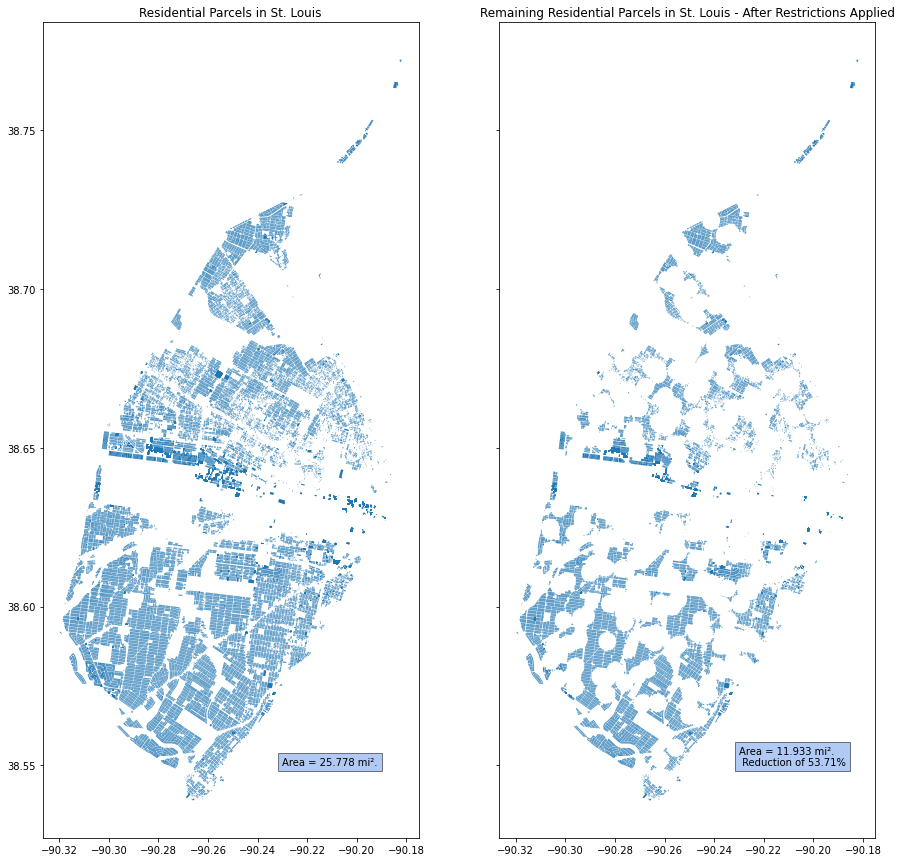

In [30]:
# same plots as above, but with before and after presentation
# visualize these two results side by side
fig, (ax1, ax2) = pyplot.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax1.set_title('Residential Parcels in St. Louis')
ax2.set_title('Remaining Residential Parcels in St. Louis - After Restrictions Applied')

ax1.text(-90.23, 38.55, text1, bbox=dict(facecolor='cornflowerblue', alpha=0.5))
ax2.text(-90.23, 38.55, text2, bbox=dict(facecolor='cornflowerblue', alpha=0.5))

gdf_parcels.plot(ax=ax1)
gdf_res_remain.plot(ax=ax2)


In [27]:
# output some summary info
print("Livable area in St. Louis City for a registered sex offender is {0:.3f} square miles.".format(area_res_remain))
print("This is a reduction of {0:.3f} square miles (-{1:.2f}%) ".format(area_diff,area_diff_percent) + 
      "compared to the total livable residential area of {0:.3f} square miles.".format(area_res))


Livable area in St. Louis City for a registered sex offender is 11.933 square miles.
This is a reduction of 13.845 square miles (-53.71%) compared to the total livable residential area of 25.778 square miles.


In [35]:
#close connection to the db
conn.close()